In [2]:
import os, datetime, time, re, warnings, gc, json, random, yaml, umap, pickle

from abc import ABCMeta, abstractmethod
from pathlib import Path
from contextlib import contextmanager
import multiprocessing
from multiprocessing import Pool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, f1_score
from sklearn import datasets, manifold, mixture, model_selection
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.cluster import MiniBatchKMeans

from scipy.sparse import vstack, csr_matrix, save_npz, load_npz, hstack

from gensim import corpora, models, similarities
from gensim.models import Word2Vec

import lightgbm as lgb
import optuna.integration.lightgbm as tuna

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

In [3]:
@contextmanager
def timer(title):
    t0 = time.time()
    print(f'[{title}] start')
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [4]:
class FeatureEngineering(metaclass=ABCMeta):
    BASE_DIR = "."
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self):
        self.name = self.__class__.__name__
        self.train = pd.DataFrame()
        self.test = pd.DataFrame()
        self.train_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_train"
        self.test_file_path = f"{Path(self.BASE_DIR)}/{self.name.lower()}_test"
    
    @abstractmethod
    def load_data(self):
        raise NotImplementedError

    @abstractmethod
    def create_features(self):
        raise NotImplementedError
        
    def run(self, use_columns=[], skip_columns=[]):
        with timer(self.name):
            self.load_data()
            self.replace_na(use_columns=use_columns, skip_columns=skip_columns)
            self.onehot_encode(use_columns=use_columns, skip_columns=skip_columns)
            self.create_features()
        
        return self
    
    def onehot_encode(self, use_columns=[], skip_columns=[], sparse=False):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        self.label_encode(use_columns, skip_columns)
        if sparse:
            encoder = OneHotEncoder(categories='auto', sparse=sparse, dtype='uint8').fit(pd.concat([self.train.loc[:, use_columns], self.test.loc[:, use_columns]]))
            m = 100000
            train = vstack([encoder.transform(self.train[i*m:(i+1)*m].loc[:, use_columns]) for i in range(self.train.shape[0] // m + 1)])
            test  = vstack([encoder.transform(self.test[i*m:(i+1)*m].loc[:, use_columns])  for i in range(self.test.shape[0] // m +  1)])
            save_npz(f"{self.train_file_path}.npz", train, compressed=True)
            save_npz(f"{self.test_file_path}.npz",  test,  compressed=True)
        else:
            self.train["is_train_date"] = 1
            self.test["is_train_date"]  = 0
            df = pd.concat([self.train, self.test])
            del self.train, self.test
            gc.collect()
            for col in use_columns:
                df = df.join(pd.get_dummies(df[col], prefix=col))
            
            self.train = df[df["is_train_date"]==1]
            self.test = df[df["is_train_date"]==0]
            self.train.drop(columns="is_train_date", inplace=True)
            self.test.drop(columns="is_train_date", inplace=True)
            
        return self
    
    def label_encode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        for col in use_columns:
            if df[col].dtype.name in ["object", "category"]:
                df[col] = df[col].astype(str)
                le = LabelEncoder().fit(df[col])
                df[col] = le.transform(df[col])+1
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
    
        return self
    
    def target_encode(self, col_name, target_name, min_samples_leaf=1, smoothing=1, noise_level=0):
        trn_series = self.train[col_name]
        tst_series = self.test[col_name]
        target = self.train[target_name]
        
        assert len(trn_series) == len(target)

        temp = pd.concat([trn_series, target], axis=1)
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        prior = target.mean()
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_trn_series.index = trn_series.index 
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        ft_tst_series.index = tst_series.index

        self.train[f"te_smoothing_{col_name}"], self.test[f"te_smoothing_{col_name}"] = self.__add_noise(ft_trn_series, noise_level), self.__add_noise(ft_tst_series, noise_level)
        
        return self
    
    def agg_transform(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"

        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
            
        for k, v in agg.items():
            if type(v) is str:
                df[f"{prefix}{k}_{v}"] = df.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    df[f"{prefix}{k}_{vv}"] = df.groupby(group)[k].transform(vv)
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def agg_transform_ratio(self, group, agg, prefix=""):
        if prefix:
            prefix += "_"
        else:
            prefix = f"{'_'.join(group)}_" if type(group) is list else f"{group}_"
        prefix = f"ratio_{prefix}"
        
        for k, v in agg.items():
            if type(v) is str:
                self.train[f"{prefix}{k}_{v}"] = self.train[k] / self.train.groupby(group)[k].transform(v)
                self.test[f"{prefix}{k}_{v}"] = self.test[k] / self.test.groupby(group)[k].transform(v)
            else:
                for vv in v:
                    self.train[f"{prefix}{k}_{vv}"] = self.train[k] / self.train.groupby(group)[k].transform(vv)
                    self.test[f"{prefix}{k}_{vv}"] = self.test[k] / self.test.groupby(group)[k].transform(vv)
        
        return self
    
    def replace_na(self, use_columns=[], skip_columns=[], fill_value=-1):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(fill_value))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(fill_value)

        return self
    
    def replace_na_mode(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mode().values[0])
            self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mode().values[0])

        return self
    
    def replace_na_mean(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].mean())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].mean())

        return self

    def replace_na_median(self, use_columns=[], skip_columns=[]):
        use_columns = use_columns if use_columns else [c for c in self.train.columns if c not in skip_columns]
        for col in use_columns:
            if isinstance(self.train[col].dtype, CategoricalDtype):
                self.train[col] = self.train[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
                self.test[col] = self.test[col].cat.add_categories(str(fill_value)).replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(str(-1))
            else:
                self.train[col] = self.train[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.train[col].median())
                self.test[col] = self.test[col].replace(np.inf, np.nan).replace(-np.inf, np.nan).fillna(self.test[col].median())

        return self
    
    def calc_topic_score(self, topic_text_columns, num_topics=5):
        df = pd.concat([self.train.loc[:, topic_text_columns], self.test.loc[:, topic_text_columns]])
        
        for col in topic_text_columns:
            texts = [[word for word in document.lower().split()] for document in df[col].values]
            dictionary = corpora.Dictionary(texts)
            bow_corpus = [dictionary.doc2bow(t) for t in texts]
            lda = models.LdaModel(bow_corpus, id2word=dictionary, num_topics=num_topics)
                        
            size = df.shape[0]
            topics = {i:[-1]*size for i in range(num_topics)}
            for i, row in enumerate(lda[bow_corpus]):
                for (topic_num, prop_topic) in row:
                    topics[topic_num][i] = prop_topic
            
            for i in range(num_topics):
                self.train[f"{col}_topic_{i}"] = topics[i][:self.train.shape[0]]
                self.test[f"{col}_topic_{i}"] = topics[i][self.train.shape[0]:]

        return self
    
    def calc_scdv_word2vec_score(self, text_col_name):
        features_num = 20
        min_word_count = 10
        context = 5
        downsampling = 1e-3
        epoch_num = 10
        clusters_num = 6
        
        df = pd.concat([self.train.loc[:, [text_col_name]], self.test.loc[:, [text_col_name]]])
        df[text_col_name] = df[text_col_name].fillna("")
        
        corpus = [self.__analyzer_cat(text) for text in df[text_col_name]]
        word2vecs = Word2Vec(sentences=corpus, iter=epoch_num, size=features_num, min_count=min_word_count, window=context, sample=downsampling)
        word_vectors = word2vecs.wv.vectors
        
        gmm = mixture.GaussianMixture(n_components=clusters_num, covariance_type='tied', max_iter=50)
        gmm.fit(word_vectors)
        
        tfidf_vectorizer = TfidfVectorizer(analyzer=self.__analyzer_cat, min_df=min_word_count)
        tfidfs = tfidf_vectorizer.fit_transform(df[text_col_name])
        
        idf_dic = dict(zip(tfidf_vectorizer.get_feature_names(), tfidf_vectorizer._tfidf.idf_))
        assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict(word_vectors)))
        soft_assign_dic = dict(zip(word2vecs.wv.index2word, gmm.predict_proba(word_vectors)))
        
        word_topic_vecs = {}
        for word in assign_dic:
            word_topic_vecs[word] = np.zeros(features_num*clusters_num, dtype=np.float32)
            for i in range(0, clusters_num):
                try:
                    word_topic_vecs[word][i*features_num:(i+1)*features_num] = word2vecs.wv[word]*soft_assign_dic[word][i]*idf_dic[word]
                except:
                    continue
        
        scdvs = np.zeros((len(df[text_col_name]), clusters_num*features_num), dtype=np.float32)

        a_min = 0
        a_max = 0

        for i, text in enumerate(df[text_col_name]):
            tmp = np.zeros(clusters_num*features_num, dtype=np.float32)
            words = self.__analyzer_cat(text)
            for word in words:
                if word in word_topic_vecs:
                    tmp += word_topic_vecs[word]
            norm = np.sqrt(np.sum(tmp**2))
            if norm > 0:
                tmp /= norm
            a_min += min(tmp)
            a_max += max(tmp)
            scdvs[i] = tmp

        p = 0.04
        a_min = a_min*1.0 / len(df[text_col_name])
        a_max = a_max*1.0 / len(df[text_col_name])
        thres = (abs(a_min)+abs(a_max)) / 2
        thres *= p
        scdvs[abs(scdvs) < thres] = 0
        
        tsne_scdv = manifold.TSNE(n_components=2).fit_transform(scdvs)
        
        self.train[f"scdv_{text_col_name}_x"] = tsne_scdv[:self.train.shape[0], 0]
        self.train[f"scdv_{text_col_name}_y"] = tsne_scdv[:self.train.shape[0], 1]        
        self.test[f"scdv_{text_col_name}_x"] = tsne_scdv[self.train.shape[0]:, 0]
        self.test[f"scdv_{text_col_name}_y"] = tsne_scdv[self.train.shape[0]:, 1]
        
        return self
    
    def yeo_johnson(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()
        
        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        pt = PowerTransformer(method='yeo-johnson')
        pt.fit(df[num_columns])

        df[num_columns] = pt.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def umap_scaler(self, skip_columns=[]):
        self.yeo_johnson(skip_columns=skip_columns)
        
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS and df[col].unique().shape[0] > 100]
        for col in num_columns:
            df[col] = df[col].replace(np.inf, np.nan)
            df[col].fillna(-9999, inplace=True)
        
        um = umap.UMAP()
        um.fit(df[num_columns])
        d = um.transform(df[num_columns])
        df["umap_d1"] = d[:, 0]
        df["umap_d2"] = d[:, 1]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def create_kmean_features(self, seed, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        for col in num_columns:
            df[col].fillna(-9999, inplace=True)
        X = df[num_columns]
        
        kmeans = MiniBatchKMeans(n_clusters=10, random_state=seed)
        kmeans.fit(X)

        df["k_class"] = kmeans.predict(X)
        train_distances = kmeans.transform(X)
        for i in range(10):
            df[f"k_distance_{i}"] = train_distances[:, i]
    
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def min_max_scaling(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        
        scaler = MinMaxScaler()
        scaler.fit(df[num_columns])
        df[num_columns] = scaler.transform(df[num_columns])
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def two_by_two(self, skip_columns=[]):
        border = self.train.shape[0]
        df = pd.concat([self.train, self.test], ignore_index=True)
        del self.train, self.test
        gc.collect()

        feats = [f for f in df.columns if f not in skip_columns]
        num_columns = [col for col in feats if df[col].dtype.name in FeatureEngineering.NUMERICS]
        targets = num_columns.copy()
        for col in num_columns:
            targets.remove(col)
            for t in targets:
                df[f"{col}_{t}_mul"] = df[col] * df[t]
                df[f"{col}_{t}_sub_left"] = df[col] / df[t]
                df[f"{col}_{t}_sub_right"] = df[t] / df[col]
        
        self.train = df.iloc[:border]
        self.test = df.iloc[border:]
        
        return self
    
    def columns_1d(self):
        self.train.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.train.columns.tolist()])
        self.test.columns = pd.Index([(e[0] + "_" + e[1].lower()) if (len(e[1]) > 0) else e[0] for e in self.test.columns.tolist()])

        return self
    
    def head(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train head: {title}")
        print(self.train.loc[:, train_cols].head(limit))
        print("----------------------------")
        print(f"test head: {title}")
        print(self.test.loc[:, test_cols].head(limit))
        print("----------------------------")
        
        return self
    
    def tail(self, title="", columns=[], limit=5):
        train_cols, test_cols = (columns, columns) if columns else (self.train.columns, self.test.columns)
        
        print(f"train tail: {title}")
        print(self.train.loc[:, train_cols].tail(limit))
        print("----------------------------")
        print(f"test tail: {title}")
        print(self.test.loc[:, test_cols].tail(limit))
        print("----------------------------")
        
        return self
    
    def save(self, format="feather", index=False):
        if format == "feather":
            self.train.to_feather(f"{self.train_file_path}.ftr")
            self.test.to_feather(f"{self.test_file_path}.ftr")
        elif format == "csv":
            self.train.to_csv(f"{self.train_file_path}.csv", index=index)
            self.test.to_csv(f"{self.test_file_path}.csv", index=index)
        
        return self
    
    def __add_noise(self, series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def __analyzer_nlp(self, text):
        stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
        text = text.lower()
        text = text.replace('\n', '')
        text = text.replace('\t', '')
        text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text)
        text = text.split(' ')

        words = []
        for word in text:
            if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None):
                continue
            if word in stop_words:
                continue
            if len(word) < 2:
                continue
            words.append(word)

        return words

    def __analyzer_cat(self, text):
        return text.split(' ')

In [5]:
class AutoML():
    SEED = 42
    EVAL_COLUMN = "_preds"
    NUMERICS = ["int16", "int32", "int64", "float16", "float32", "float64"]
    
    def __init__(self, engine):
        if not isinstance(engine, FeatureEngineering): raise TypeError
        self.engine = engine
    
    def run(self, scenario):
        self.__seed_everything(AutoML.SEED)
        self.target = scenario["target"]
        self.engine.load_data()

        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])

        self.engine.label_encode(skip_columns=[self.target])        
        self.__set_column_type()

        for command in scenario["feature_engineering"]:
            self.__do(command)

        if "feature_selection" in scenario:
            self.__feature_selection(scenario["feature_selection"])

        if "drop_features" in scenario:
            self.__drop_features(scenario["drop_features"])
        
        params = {
            'objective': scenario["objective"],
            'boosting_type': scenario["boosting_type"], 
            'metric': scenario["metric"],
            'n_jobs': -1,
            'seed': AutoML.SEED
        }
        tuned = self.__hyper_parameter_tuning(params)
        params = dict(params, **tuned)

        for i in range(1, 6):
            AutoML.SEED = 42**i
            self.__seed_everything(AutoML.SEED)
            params["seed"] = AutoML.SEED
            self.predicts, importance = self.__train(params)
            
            metric = None
            if "eval_metric" in scenario:
                metric = scenario["eval_metric"]
            param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]), metric)
            
            with open(f"./vortex/param_{param_with_score['score']}.json", "w") as fw:
                json.dump(param_with_score, fw)
            with open(f"./vortex/scenario_{param_with_score['score']}.yml", "w") as fw:
                fw.write(yaml.dump(scenario, default_flow_style=False))
            self.engine.train.to_pickle(f"./vortex/train_{param_with_score['score']}.pkl")
            self.engine.test.to_pickle(f"./vortex/test_{param_with_score['score']}.pkl")
        
    def greedy_forward_selection(self, base_score, base_path="./"):
        self.__seed_everything(AutoML.SEED)
        best_score = 0.0
        selected = set([])
        params = None
        scenario = None
        del self.engine.train, self.engine.test
        with open(f"{base_path}/param_{base_score}.json") as f:
            params = json.load(f)
        with open(f"{base_path}/scenario_{base_score}.yml", "r") as yml:
            scenario = yaml.safe_load(yml)
        self.target = scenario["target"]
        
        train = pd.read_pickle(f"{base_path}/train_{base_score}.pkl")
        test = pd.read_pickle(f"{base_path}/test_{base_score}.pkl")
        
        train_x = [f for f in train.columns if f not in self.target]
        while True:
            if len(selected) == len(train_x): break
            
            scores = []
            for col in train_x:
                if col not in selected:
                    feats = list(selected) + [col]
                    self.engine.train = train[list(feats)+[self.target]]
                    self.engine.test = test[feats]
                    self.predicts, importance = self.__train(params)
                    param_with_score = self.__evaluate(params, pd.read_csv(scenario["eval_file_path"]))
                    scores.append((col, param_with_score["score"]))
            
            b_feature, b_score = sorted(scores, key=lambda tpl: tpl[1], reverse=True)[0]
            print(f"b_score: {b_score}")
            print(f"best_score: {best_score}")
            if b_score > best_score:
                selected.add(b_feature)
                best_score = b_score
                print(f'selected:{b_feature}')
                print(f'score:{b_score}')
            else:
                break
        
        print(f'selected features: {selected}')
        with open("selected.pkl", "wb") as fw:
            pickle.dump(selected, fw)
            
    def __do(self, command):
        if command == "fill_numeric_na":
            self.__fill_numeric_na()
        if command == "binning":
            self.__binning()
        if command == "transformation":
            self.__transformation()
        if command == "topic_encoding":
            self.__topic_encoding()
        if command == "umap":
            self.engine.umap_scaler(skip_columns=[self.target])
        if command == "kmean_features":
            self.engine.create_kmean_features(skip_columns=[self.target], seed=AutoML.SEED)
        if command == "min_max_scaling":
            self.engine.min_max_scaling(skip_columns=[self.target])
        if command == "two_by_two":
            self.engine.two_by_two(skip_columns=[self.target])
    
    def __evaluate(self, params, actuals, metric):
        calc_score_param = {"metric": metric}
        actuals[AutoML.EVAL_COLUMN] = self.predicts
        if params["objective"] == "binary":
            actuals.loc[actuals[AutoML.EVAL_COLUMN]>=0.5, AutoML.EVAL_COLUMN] = 1
            actuals.loc[actuals[AutoML.EVAL_COLUMN]<0.5, AutoML.EVAL_COLUMN] = 0
            actuals[AutoML.EVAL_COLUMN] = actuals[AutoML.EVAL_COLUMN].astype("int")
        
        score = self.__calc_score(calc_score_param, actuals[self.target], actuals[AutoML.EVAL_COLUMN])
        params["score"] = score
        print(f"Score: {score}")
        return params
    
    def __transformation(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        aggs = ["min", "max", "mean", "std"]
        for col in feats:
            if self.engine.train[col].dtype.name == "category":
                self.engine.agg_transform(group=[col], agg={f"{col}": ["count"]})
            for c in num_columns:
                if c == col: continue
                self.engine.agg_transform(group=[col], agg={f"{c}": aggs})
                for agg in aggs:
                    if self.engine.train[self.engine.train[f"{col}_{c}_{agg}"].isnull()].shape[0] > 0:
                        self.engine.train.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)
                        self.engine.test.drop(columns=[f"{col}_{c}_{agg}"], inplace=True)

    def __fill_numeric_na(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        cat_columns = [col for col in feats if self.engine.train[col].dtype.name == "category"]
        groups = []
        for c in cat_columns:
            if self.engine.train[self.engine.train[c].isnull()].shape[0] == 0:
                if self.engine.train.groupby(c).size().shape[0] / self.engine.train.shape[0] < 0.1:
                    groups.append(c)
        for n in num_columns:
            if len(groups) > 0:
                self.engine.agg_transform(group=groups, agg={f"{n}": ["mean"]}, prefix="_tmp")
                self.engine.train[n].fillna(self.engine.train[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test[n].fillna(self.engine.test[f"_tmp_{n}_mean"], inplace=True)
                self.engine.train.drop(columns=[f"_tmp_{n}_mean"], inplace=True)
                self.engine.test.drop(columns=[f"_tmp_{n}_mean"], inplace=True)

    def __binning(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()

        for c in num_columns:
            if df[c].unique().shape[0] > 100:
                df[f"{c}_bin"] = pd.cut(df[c], 10, labels=False)
        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __topic_encoding(self):
        self.__create_topic_text()
        self.engine.calc_topic_score(topic_text_columns=["topic_text"], num_topics=5)
        self.__drop_features(["topic_text"])

    def __create_topic_text(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        num_columns = [col for col in feats if self.engine.train[col].dtype.name in AutoML.NUMERICS]
        border = self.engine.train.shape[0]
        df = pd.concat([self.engine.train, self.engine.test], ignore_index=True)
        del self.engine.train, self.engine.test
        gc.collect()
        
        df["topic_text"] = ""
        for c in num_columns:
            df["topic_text"] = df["topic_text"].astype(str) + " " + df[c].astype(str)

        self.engine.train = df.iloc[:border]
        self.engine.test = df.iloc[border:]
    
    def __set_column_type(self):
        feats = [f for f in self.engine.train.columns if f not in self.target]
        for col in feats:
            col_type = self.engine.train[col].dtypes
            if self.engine.train[col].unique().shape[0] < 20:
                self.engine.train[col] = self.engine.train[col].astype("category")
                self.engine.test[col] = self.engine.test[col].astype("category")

    def __drop_features(self, cols):
        feats = [f for f in self.engine.train.columns if f in cols]
        self.engine.train.drop(columns=feats, inplace=True)
        self.engine.test.drop(columns=feats, inplace=True)
    
    def __feature_selection(self, cols):
        self.engine.train = self.engine.train.loc[:, list(cols)+[self.target]]
        self.engine.test = self.engine.test.loc[:, cols]
    
    def __hyper_parameter_tuning(self, params):
        train, valid = model_selection.train_test_split(self.engine.train, test_size=0.33, random_state=AutoML.SEED, shuffle=True)
        feats = [f for f in train.columns if f not in self.target]
        
        lgb_train = tuna.Dataset(train[feats], label=train[self.target].values)
        lgb_valid = tuna.Dataset(valid[feats], label=valid[self.target].values)
        best_params, tuning_history = dict(), list()

        model = tuna.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100,
                        best_params=best_params,
                        tuning_history=tuning_history
                        )

        return best_params
    
    def __adversarial_validation(self, num_folds=5):
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        feats = [f for f in self.engine.train.columns if f not in self.target]
        train = self.engine.train[feats]
        test = self.engine.test[feats]
        train[self.target] = 0
        test[self.target] = 1
        
        df = pd.concat([train, test], ignore_index=True)
        del train, test
        gc.collect()
        
        oof_preds = np.zeros(df.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(df[feats], df[self.target])):
            train_x, train_y = df[feats].iloc[train_idx], df[self.target].iloc[train_idx]
            valid_x, valid_y = df[feats].iloc[valid_idx], df[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            params = {'num_leaves': 50,
                     'min_data_in_leaf': 30, 
                     'objective':'binary',
                     'max_depth': 5,
                     'learning_rate': 0.1,
                     "min_child_samples": 20,
                     "boosting": "gbdt",
                     "feature_fraction": 0.9,
                     "bagging_freq": 1,
                     "bagging_fraction": 0.9 ,
                     "bagging_seed": 44,
                     "metric": 'auc',
                     "verbosity": -1}

            model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_valid],
                        valid_names=['train', 'valid'],
                        num_boost_round=1000, 
                        early_stopping_rounds=100,
                        verbose_eval=100
                        )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        self.__display_importances(feature_importance_df)
        
        return sum(scores)/len(scores), feature_importance_df
        
    def __train(self, params, num_folds=5, stratified=False):
        if stratified:
            folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)
        else:
            folds = KFold(n_splits=num_folds, shuffle=True, random_state=AutoML.SEED)

        feats = [f for f in self.engine.train.columns if f not in self.target]
        oof_preds = np.zeros(self.engine.train.shape[0])
        sub_preds = np.zeros(self.engine.test.shape[0])
        feature_importance_df = pd.DataFrame()

        scores = []
        for n_fold, (train_idx, valid_idx) in enumerate(folds.split(self.engine.train[feats], self.engine.train[self.target])):
            train_x, train_y = self.engine.train[feats].iloc[train_idx], self.engine.train[self.target].iloc[train_idx]
            valid_x, valid_y = self.engine.train[feats].iloc[valid_idx], self.engine.train[self.target].iloc[valid_idx]

            lgb_train = lgb.Dataset(train_x,
                                    label=train_y,
                                    free_raw_data=False)
            lgb_valid = lgb.Dataset(valid_x,
                                   label=valid_y,
                                   free_raw_data=False)
            model = lgb.train(
                            params,
                            lgb_train,
                            valid_sets=[lgb_train, lgb_valid],
                            valid_names=['train', 'valid'],
                            num_boost_round=1000, 
                            early_stopping_rounds=100,
                            verbose_eval=100
                            )

            oof_preds[valid_idx] = model.predict(valid_x, num_iteration=model.best_iteration)
            sub_preds += model.predict(self.engine.test[feats], num_iteration=model.best_iteration) / folds.n_splits

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = feats
            fold_importance_df["importance"] = np.log1p(model.feature_importance(importance_type='gain', iteration=model.best_iteration))
            fold_importance_df["fold"] = n_fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            scores.append(self.__calc_score(params, valid_y, oof_preds[valid_idx]))

        print('CV : %.6f' % (sum(scores)/len(scores)))
        self.__display_importances(feature_importance_df)

        return sub_preds, feature_importance_df
    
    def __display_importances(self, feature_importance_df_):
        all_cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False).index
        feature_importance_df_.loc[feature_importance_df_.feature.isin(all_cols)].to_csv("feature_importance.csv", index=False)

        cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
        best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

        plt.figure(figsize=(8, 10))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('LightGBM Features (avg over folds)')
        plt.tight_layout()
        plt.savefig('lgbm_importances.png')
    
    def __calc_score(self, params, actuals, preds):
        if params["metric"] == "rmse":
            return np.sqrt(mean_squared_error(actuals, preds))
        if params["metric"] in ["cross_entropy", "binary_logloss"]:
            return log_loss(actuals, preds)
        if params["metric"] == "auc":
            return roc_auc_score(actuals, preds)
        if params["metric"] == "f1":
            return f1_score(actuals, preds)

    def __seed_everything(self, seed):
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
        np.random.seed(seed)

In [6]:
class Sample(FeatureEngineering):
    def load_data(self):
        self.train = pd.read_csv("../input/building_structure/train.csv")
        self.test = pd.read_csv("../input/building_structure/test.csv")
        
        return self
    
    def create_features(self):
        return self
    
    def create_topic_text(self):
        return self

In [7]:
# with open("../input/building_structure/scenario.yml", "r") as yml:
#     scenario = yaml.safe_load(yml)

In [8]:
# ml = AutoML(engine=Sample())

In [9]:
df = pd.read_csv("../input/building_structure/20200311_対象案件リスト_送付用.csv")
df.head()

,no,name,usage,place,floor_area,floor,structure_type
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造


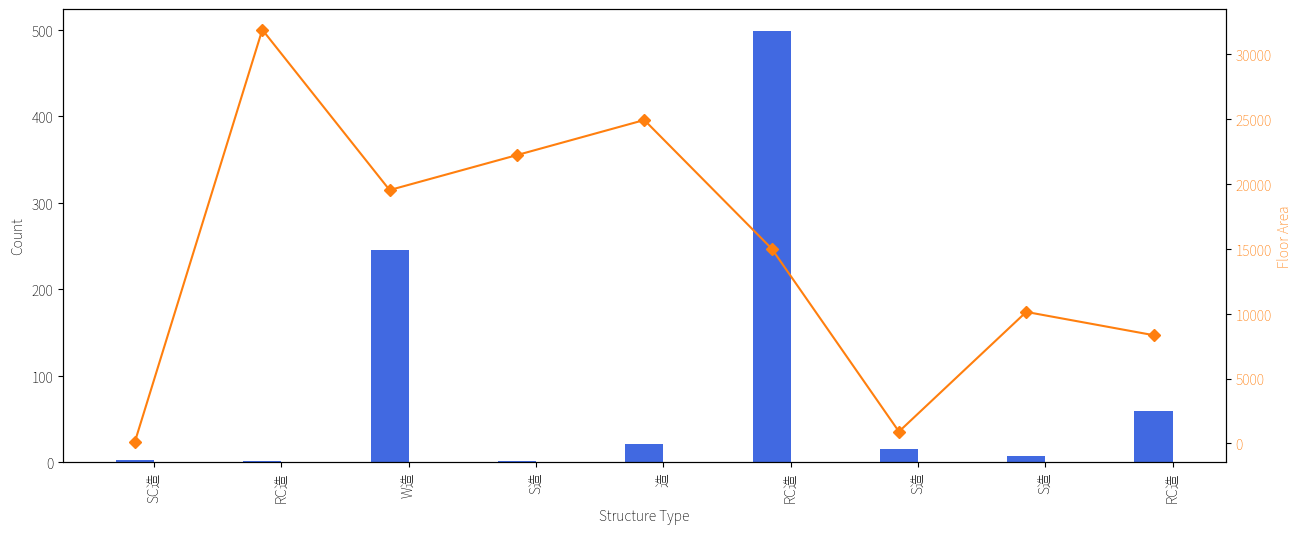

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
tt = df.groupby("structure_type").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Structure Type");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(df["structure_type"], rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("structure_type")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

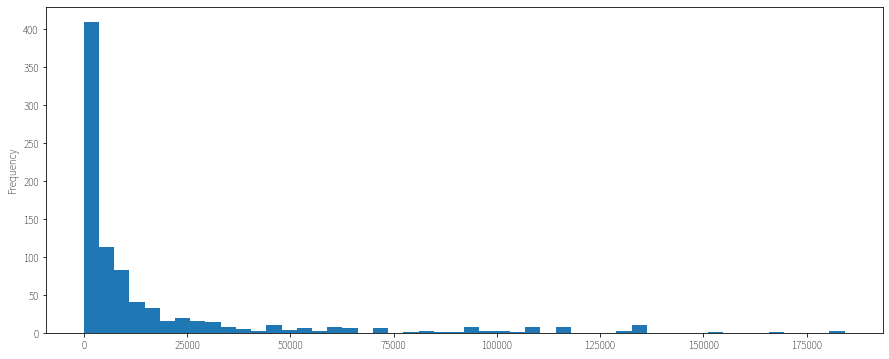

In [11]:
plt.rc('figure', figsize=(15, 6))
df["floor_area"].plot.hist(bins=50)

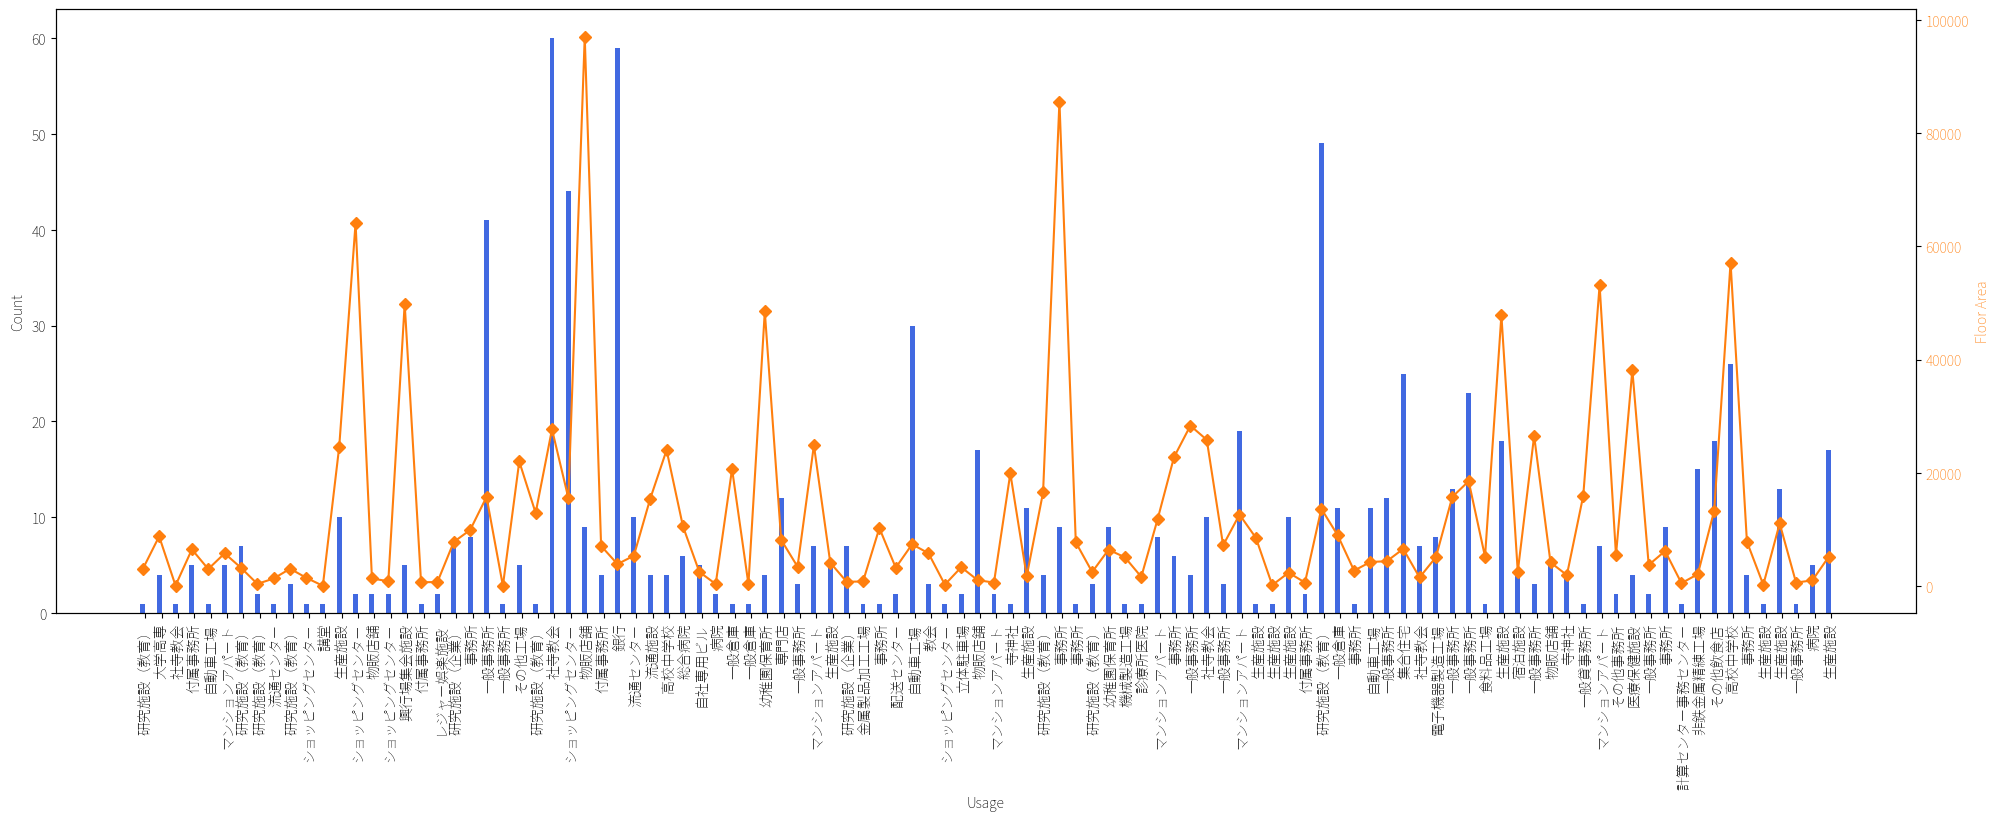

In [12]:
fig, axes = plt.subplots(1, 1, figsize=(24, 8), dpi=100)
tt = df.groupby("usage").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Usage");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(df["usage"], rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("usage")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

In [13]:
df["pref_code"] = np.nan
df.loc[df["place"].str.startswith("北海道"), "pref_code"] = "01"
df.loc[df["place"].str.startswith("青森"), "pref_code"] = "02"
df.loc[df["place"].str.startswith("岩手"), "pref_code"] = "03"
df.loc[df["place"].str.startswith("宮城"), "pref_code"] = "04"
df.loc[df["place"].str.startswith("秋田"), "pref_code"] = "05"
df.loc[df["place"].str.startswith("山形"), "pref_code"] = "06"
df.loc[df["place"].str.startswith("福島"), "pref_code"] = "07"
df.loc[df["place"].str.startswith("茨城"), "pref_code"] = "08"
df.loc[df["place"].str.startswith("栃木"), "pref_code"] = "09"
df.loc[df["place"].str.startswith("群馬"), "pref_code"] = "10"
df.loc[df["place"].str.startswith("埼玉"), "pref_code"] = "11"
df.loc[df["place"].str.startswith("千葉"), "pref_code"] = "12"
df.loc[df["place"].str.startswith("東京都"), "pref_code"] = "13"
df.loc[df["place"].str.startswith("神奈川"), "pref_code"] = "14"
df.loc[df["place"].str.startswith("新潟"), "pref_code"] = "15"
df.loc[df["place"].str.startswith("富山"), "pref_code"] = "16"
df.loc[df["place"].str.startswith("石川"), "pref_code"] = "17"
df.loc[df["place"].str.startswith("福井"), "pref_code"] = "18"
df.loc[df["place"].str.startswith("山梨"), "pref_code"] = "19"
df.loc[df["place"].str.startswith("長野"), "pref_code"] = "20"
df.loc[df["place"].str.startswith("岐阜"), "pref_code"] = "21"
df.loc[df["place"].str.startswith("静岡"), "pref_code"] = "22"
df.loc[df["place"].str.startswith("愛知"), "pref_code"] = "23"
df.loc[df["place"].str.startswith("三重"), "pref_code"] = "24"
df.loc[df["place"].str.startswith("滋賀"), "pref_code"] = "25"
df.loc[df["place"].str.startswith("京都"), "pref_code"] = "26"
df.loc[df["place"].str.startswith("大阪"), "pref_code"] = "27"
df.loc[df["place"].str.startswith("兵庫"), "pref_code"] = "28"
df.loc[df["place"].str.startswith("奈良"), "pref_code"] = "29"
df.loc[df["place"].str.startswith("和歌山"), "pref_code"] = "30"
df.loc[df["place"].str.startswith("鳥取"), "pref_code"] = "31"
df.loc[df["place"].str.startswith("島根"), "pref_code"] = "32"
df.loc[df["place"].str.startswith("岡山"), "pref_code"] = "33"
df.loc[df["place"].str.startswith("広島"), "pref_code"] = "34"
df.loc[df["place"].str.startswith("山口"), "pref_code"] = "35"
df.loc[df["place"].str.startswith("徳島"), "pref_code"] = "36"
df.loc[df["place"].str.startswith("香川"), "pref_code"] = "37"
df.loc[df["place"].str.startswith("愛媛"), "pref_code"] = "38"
df.loc[df["place"].str.startswith("高知"), "pref_code"] = "39"
df.loc[df["place"].str.startswith("福岡"), "pref_code"] = "40"
df.loc[df["place"].str.startswith("佐賀"), "pref_code"] = "41"
df.loc[df["place"].str.startswith("長崎"), "pref_code"] = "42"
df.loc[df["place"].str.startswith("熊本"), "pref_code"] = "43"
df.loc[df["place"].str.startswith("大分"), "pref_code"] = "44"
df.loc[df["place"].str.startswith("宮崎"), "pref_code"] = "45"
df.loc[df["place"].str.startswith("鹿児島"), "pref_code"] = "46"
df.loc[df["place"].str.startswith("沖縄"), "pref_code"] = "47"
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,NaN


In [14]:
df["country_code"] = np.nan
df.loc[df["pref_code"].notnull(), "country_code"] = "392"
df.loc[df["place"].str.startswith("海外タイ"), "country_code"] = "764"
df.loc[df["place"].str.startswith("海外インド"), "country_code"] = "356"
df.loc[df["place"].str.startswith("海外ベトナム"), "country_code"] = "704"
df.loc[df["place"].str.startswith("海外中国"), "country_code"] = "156"
df.loc[df["place"].str.startswith("海外香港"), "country_code"] = "344"
df.loc[df["place"].str.startswith("海外フィリピン"), "country_code"] = "608"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.loc[df["place"].str.startswith("海外インドネシア"), "country_code"] = "360"
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,NaN,764


In [15]:
le = LabelEncoder()
le.fit(df.loc[(df["pref_code"].isnull())&(df["country_code"].notnull()), "place"])
df.loc[(df["pref_code"].isnull())&(df["country_code"].notnull()), "pref_code"] = le.transform(df.loc[(df["pref_code"].isnull())&(df["country_code"].notnull()), "place"])
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,8,764


In [16]:
df.loc[(df["country_code"]!="392")&(df["pref_code"].notnull()), "pref_code"] = df.loc[(df["country_code"]!="392")&(df["pref_code"].notnull()), "pref_code"].astype(int) + 47
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,55,764


In [17]:
df.fillna(-999, inplace=True)
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,55,764


In [18]:
df["floor_1"] = df["floor"].apply(lambda x: x.split("-")[0])
df["floor_2"] = df["floor"].apply(lambda x: x.split("-")[1])
df["floor_3"] = df["floor"].apply(lambda x: x.split("-")[2])
df.drop(columns=["floor"], inplace=True)
df.head()

,no,name,usage,place,floor_area,structure_type,pref_code,country_code,floor_1,floor_2,floor_3
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,SC造,14,392,1,6,0
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,RC造,13,392,0,0,0
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,W造,13,392,0,1,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,S造,15,392,0,3,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,造,55,764,0,0,0


In [19]:
le = LabelEncoder()
le.fit(df["usage"])
df["usage"] = le.transform(df["usage"])

le = LabelEncoder()
le.fit(df["structure_type"])
df["structure_type"] = le.transform(df["structure_type"])
df.head()

,no,name,usage,place,floor_area,structure_type,pref_code,country_code,floor_1,floor_2,floor_3
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,77,神奈川県横浜市都筑区,22214.97,3,14,392,1,6,0
1,79 08B250B,国立音楽大学新校舎建設工事,47,東京都立川市,17277.40,2,13,392,0,0,0
2,79 09A245A,八幡大神社楼門新築計画,78,東京都三鷹市,30.12,6,13,392,0,1,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,30,新潟県五泉市,3400.00,5,15,392,0,3,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,83,海外タイ アユタヤ県,500.00,8,55,764,0,0,0


In [20]:
train = df.drop(columns=["no", "name", "place"])
train.head()

,usage,floor_area,structure_type,pref_code,country_code,floor_1,floor_2,floor_3
0,77,22214.97,3,14,392,1,6,0
1,47,17277.40,2,13,392,0,0,0
2,78,30.12,6,13,392,0,1,0
3,30,3400.00,5,15,392,0,3,0
4,83,500.00,8,55,764,0,0,0


In [21]:
# scaler = StandardScaler()
# scaler.fit(train.loc[:, ["floor_area", "pref_code", "country_code", "floor_1", "floor_2", "floor_3"]])

In [22]:
# train[["floor_area", "pref_code", "country_code", "floor_1", "floor_2", "floor_3"]] = scaler.transform(train[["floor_area", "pref_code", "country_code", "floor_1", "floor_2", "floor_3"]])
# train.head()

In [23]:
kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
kmeans.fit(train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [24]:
df = pd.read_csv("../input/building_structure/20200311_対象案件リスト_送付用.csv")
df["k_class"] = kmeans.predict(train)

In [25]:
df.head()

,no,name,usage,place,floor_area,floor,structure_type,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,9
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,4
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,0


In [26]:
df.groupby("k_class").size()

k_class
0    443
1     16
2     23
3     18
4     78
5     21
6     27
7    167
8     16
9     41
dtype: int64

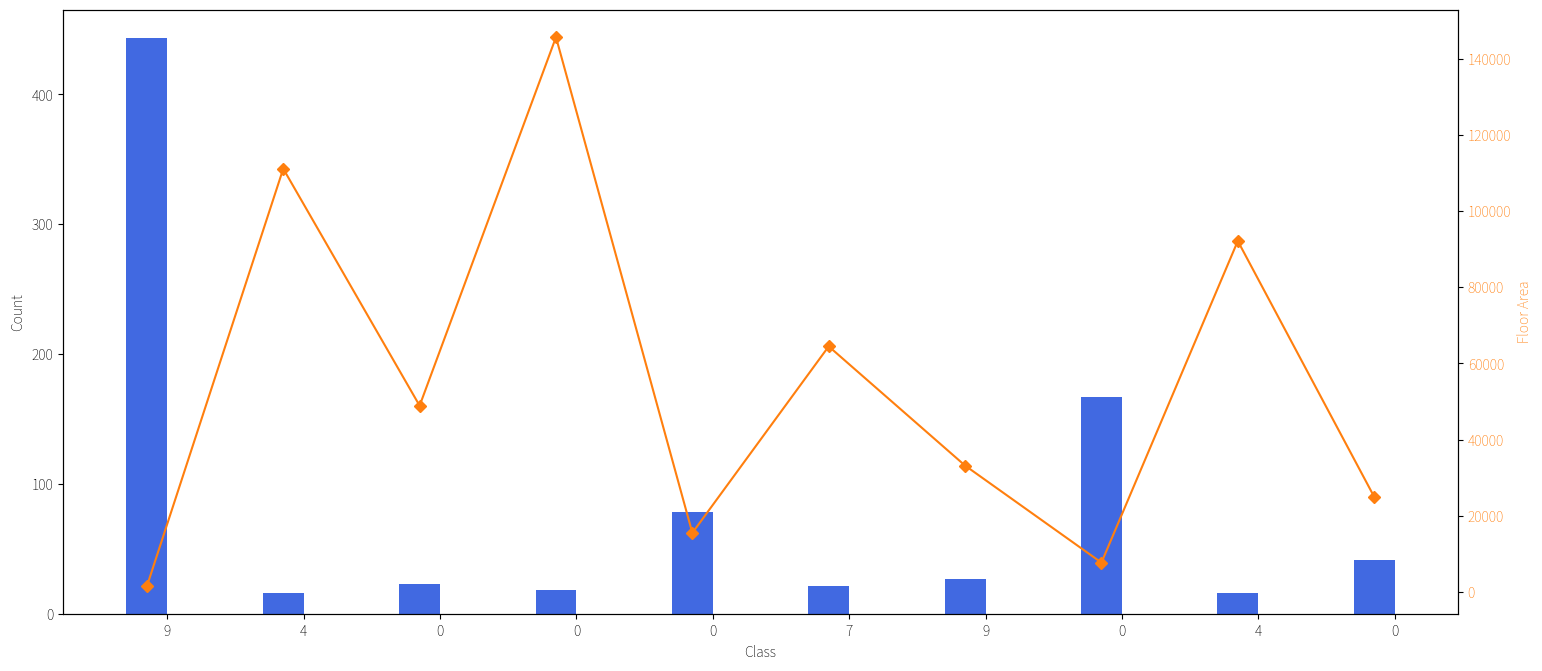

In [27]:
fig, axes = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
tt = df.groupby("k_class").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Class");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(df["k_class"], rotation=0)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("k_class")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

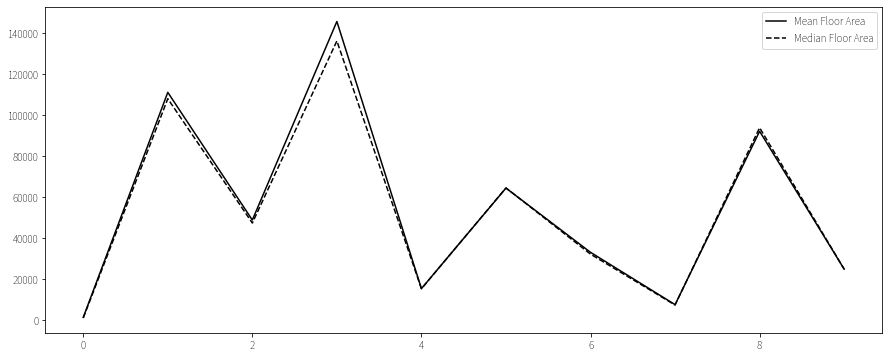

In [42]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(df.groupby("k_class")["floor_area"].mean(), 'k', label='Mean Floor Area')
ax.plot(df.groupby("k_class")["floor_area"].median(), 'k--', label='Median Floor Area')
ax.legend(loc='best')

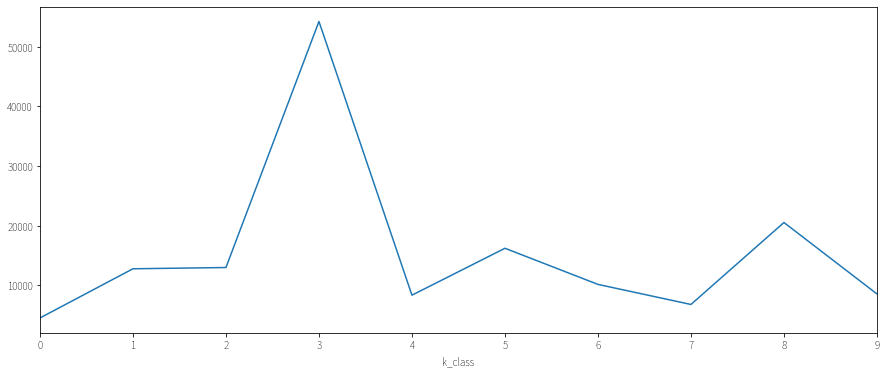

In [77]:
tmp = df.groupby("k_class").agg({"floor_area": ["min", "max"]})
tmp["diff"] = tmp[("floor_area", "max")] - tmp[("floor_area", "min")]
tmp["diff"].plot()

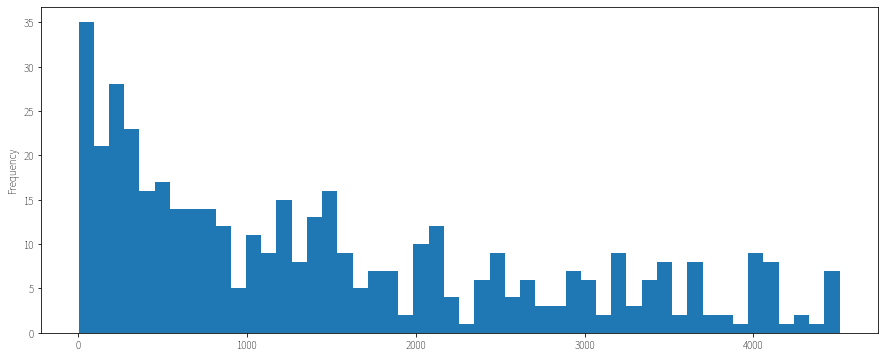

In [44]:
df[df["k_class"]==0]["floor_area"].plot.hist(bins=50)

In [29]:
df[df["k_class"]==0]

,no,name,usage,place,floor_area,floor,structure_type,k_class
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,0
7,79 09A540C,花王和歌山新研究施設建設計画（温室）,研究施設（教育）,和歌山県和歌山市,2361.00,0-3-0,S造,0
9,79 08B129F,慶應義塾（矢上Ｆ）テクロノジー棟新築,研究施設（教育）,神奈川県横浜市港北区,1895.78,0-3-0,RC造,0
...,...,...,...,...,...,...,...,...
842,72 18A020,アトムリビンテック広島営業所新築計画,一般倉庫,広島県広島市西区,1126.19,0-6-0,S造,0
843,76 18A020,日本生命会郡山支社会津営業部新築工事,生保シリ－ズ,福島県会津若松市,379.00,0-1-0,S造,0
844,79 17A315D,昭南荘建替計画・家具,個人住宅,神奈川県足柄下郡箱根町,350.00,1-1-0,W造,0
845,74 18B004,日本生命鹿児島支社串木野オフィス新築,一般事務所,鹿児島県いちき串木野市,310.00,0-1-0,S造,0


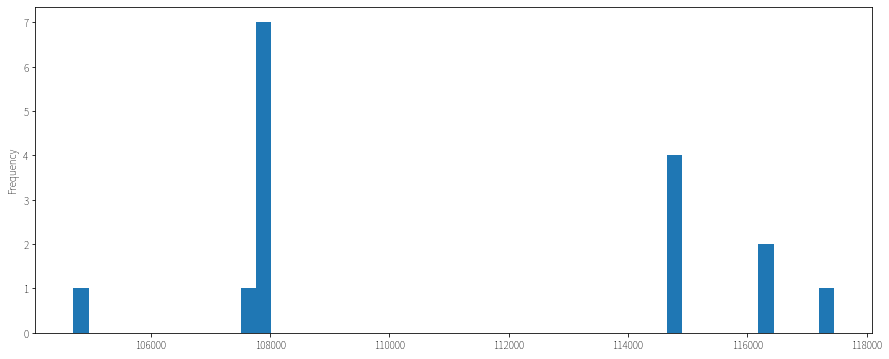

In [65]:
df[df["k_class"]==1]["floor_area"].plot.hist(bins=50)

In [68]:
df[df["k_class"]==1]

,no,name,usage,place,floor_area,floor,structure_type,k_class
21,79 09A190B,京橋三丁目プロジェクト,一般事務所,東京都中央区,117460.96,4-24-0,S造,1
80,79 09A190D,京橋三丁目プロジェクト設計変更対応,一般事務所,東京都中央区,116319.00,3-24-0,S造,1
81,79 09A190E,京橋三丁目プロジェクトＨ２２設計変更対応,一般事務所,東京都中央区,116319.00,3-24-0,S造,1
256,79 10B522B,プロロジスパーク習志野４,一般倉庫,千葉県習志野市,107546.00,0-5-1,RC造,1
345,79 09A190G,京橋三丁目プロジェクトＤ社入居対応工事,一般事務所,東京都中央区,114806.00,3-24-0,S造,1
369,79 09A190H,京橋三丁目プロジェクトＳ社入居対応工事,一般事務所,東京都中央区,114806.00,3-24-0,S造,1
405,79 09A190F,京橋三丁目プロジェクトＢ社入居対応工事,一般事務所,東京都中央区,114806.00,3-24-0,S造,1
409,79 09A190I,京橋三丁目プロジェクト６階環境Ｓ変更工事,一般事務所,東京都中央区,114806.00,3-24-0,S造,1
503,79 14A513A,※エプソン・プレシジョンフィリピン３期,弱電機器製造工場,海外フィリピン,108000.00,0-2-0,RC造,1
536,64 13A046A,プロロジスパーク吉見プロジェクト,一般倉庫,埼玉県比企郡吉見町,104704.60,0-3-0,S造,1


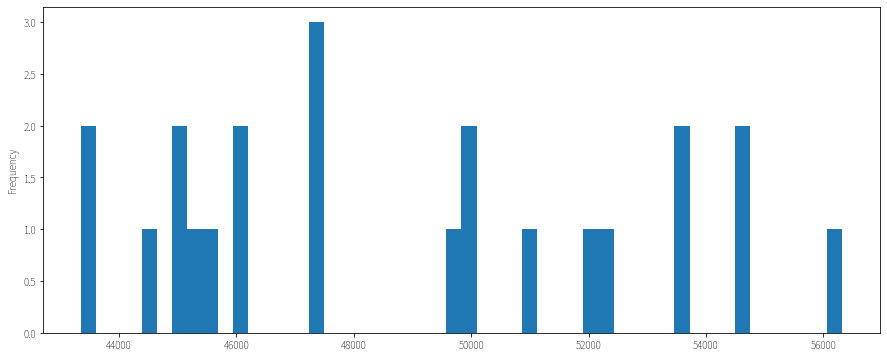

In [69]:
df[df["k_class"]==2]["floor_area"].plot.hist(bins=50)

In [31]:
df[df["k_class"]==2]

,no,name,usage,place,floor_area,floor,structure_type,k_class
10,79 04A763E,島忠調布店新築工事（工期延長後）,ショッピングセンタ－,東京都調布市,50000.00,0-6-0,S造,2
13,79 04A763D,島忠調布店新築工事（テナント対応）,ショッピングセンタ－,東京都調布市,50000.00,0-6-0,S造,2
33,79 09A333B,順天堂本郷地区再編事業（実施設計）,総合病院,東京都文京区,45385.87,3-21-0,S造,2
101,79 08B315C,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,一般事務所,東京都千代田区,52349.29,3-15-1,RC造,2
119,79 08B315D,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,一般事務所,東京都千代田区,51000.00,4-14-0,RC造,2
228,74S11A041,福岡徳洲会病院建替工事構造検討,総合病院,福岡県春日市,53695.00,2-10-0,RC造,2
317,79 08B315F,中央合同庁舎第８号館整備（Ａ棟外装改修）,一般事務所,東京都千代田区,52067.00,0-0-0,造,2
319,79 06B617E,幕張ベイタウンＳＨ２街区（その２）,マンションアパ－ト,千葉県千葉市美浜区,46142.45,0-31-1,RC造,2
355,79 11B418A,佐久総合病院佐久医療センターＶＥ支援,総合病院,長野県佐久市,49635.37,1-4-0,RC造,2
386,79 11B427A,東芝半導体工場タイ（ＴＳＴ）４期工事,電子機器製造工場,海外タイ バンコク近郊,43349.00,0-3-1,RC造,2


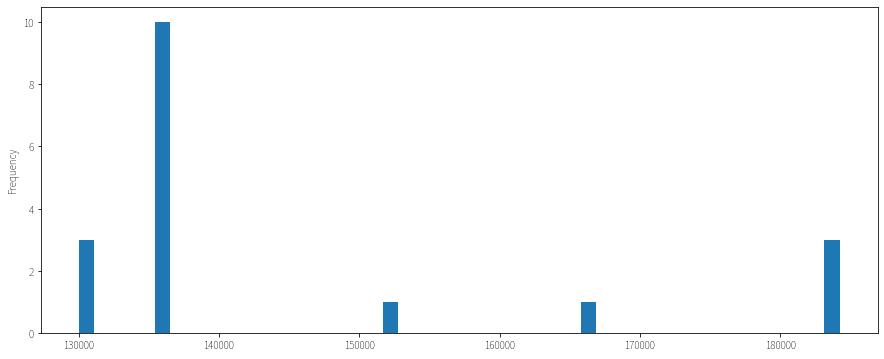

In [70]:
df[df["k_class"]==3]["floor_area"].plot.hist(bins=50)

In [32]:
df[df["k_class"]==3]

,no,name,usage,place,floor_area,floor,structure_type,k_class
31,79 07B471B,プロロジスパーク埼玉川島Ⅱ期,流通施設,埼玉県比企郡川島町,166659.70,0-5-1,RC造,3
75,79 10B200A,ホンダ寄居工場建設１期建築工事Ｓ工区,自動車工場,埼玉県大里郡寄居町,184227.00,0-4-0,S造,3
242,79 11A860A,※ＨＭＳＩ第３工場建設工事,生産施設,海外インド カルナタカ州,151950.19,0-2-0,S造,3
457,79 10B200D,ホンダ寄居工場建設１期Ｓ工区テナント対応,自動車工場,埼玉県大里郡寄居町,184227.00,0-4-0,S造,3
470,79 10B200C,ホンダ寄居工場建設１期Ｓ工区２月以降,自動車工場,埼玉県大里郡寄居町,184227.00,0-4-0,S造,3
491,79 10A100E,東京団地冷蔵再整備計画－基本設計標準業務,一般冷蔵冷凍倉庫,東京都大田区,135442.00,0-5-0,RC造,3
496,79 13B395E,東芝四日市工場ＮＹ２棟３（ＰＨＡＳＥ２）,電子機器製造工場,三重県四日市市,130000.00,0-5-0,S造,3
514,79 13B395A,東芝四日市工場ＮＹ２棟（Ｐｈａｓｅ１）,電子機器製造工場,三重県四日市市,136250.00,0-5-0,S造,3
537,79 13B395B,東芝四日市工場ＮＹ２棟（Ｐｈａｓｅ１）２,電子機器製造工場,三重県四日市市,130000.00,0-5-0,S造,3
568,79 13B395F,東芝四日市工場ＮＹ２棟４（ＰＨＡＳＥ３）,電子機器製造工場,三重県四日市市,130000.00,0-5-0,S造,3


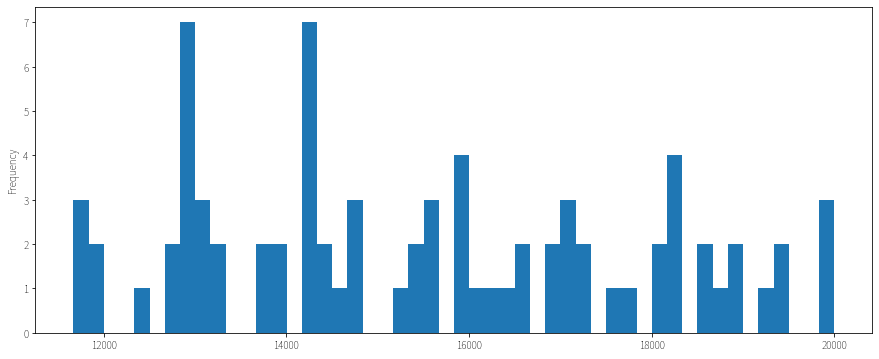

In [71]:
df[df["k_class"]==4]["floor_area"].plot.hist(bins=50)

In [33]:
df[df["k_class"]==4]

,no,name,usage,place,floor_area,floor,structure_type,k_class
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,4
8,79 09A556A,※東邦薬品熊本物流センター計画,流通センタ－,熊本県荒尾市,15278.40,0-2-0,RC造,4
11,79 06B190B,上野学園ホール棟テナントＡ対応,講堂,東京都台東区,15948.79,2-13-0,SRC造,4
18,79 09A255B,伊豆ベロドローム建設計画,レジャ－娯楽施設,静岡県伊豆市,12905.00,1-3-0,RC造,4
23,93 09A037,Ｐ＆ＧベトナムＢｅｎＣａｔ工場新築工事,その他工場,海外ベトナム ビンドゥオン,15900.00,0-2-0,S造,4
32,79 05A520F,目黒星美学園学校１期家具工事２,高校中学校,東京都世田谷区,13000.00,0-0-0,造,4
43,93 09A013,常州ピジョン新工場新築工事,研究施設（企業）,海外中国 江蘇省,13800.00,0-2-0,RC造,4
52,79 09B514A,大和ハウス工業 南青山六丁目計画,マンションアパ－ト,東京都港区,13783.21,2-8-0,RC造,4
82,64 10A074B,松屋フーズ川島物流センター計画実施設計,食料品工場,0,13186.00,0-3-0,S造,4
97,79 05AA58E,横浜清風高校建替提案競技（外構工事）,高校中学校,神奈川県横浜市保土ケ谷区,16515.00,0-4-0,RC造,4


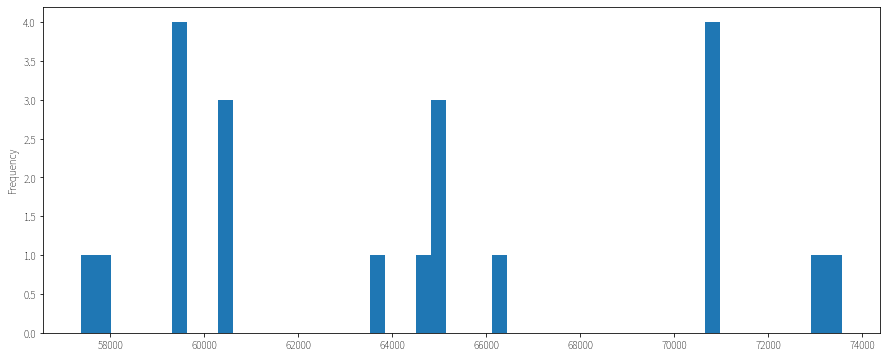

In [72]:
df[df["k_class"]==5]["floor_area"].plot.hist(bins=50)

In [34]:
df[df["k_class"]==5]

,no,name,usage,place,floor_area,floor,structure_type,k_class
14,79 08A148B,イオンモール甲府昭和町ＳＣジャスコＢ工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,5
15,79 08A148C,イオンモール甲府昭和町ＳＣ（防災計画）,ショッピングセンタ－,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,5
16,79 08A148D,イオンモール甲府昭和町ＳＣ（シネマ）,興行場集会施設,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,5
26,79 08A148E,イオンモール甲府昭和町ＳＣ（熱源受託工事,ショッピングセンタ－,山梨県中巨摩郡昭和町,70657.00,0-3-0,RC造,5
83,79 10B078A,イビデン大垣中央事業場第２工場棟,生産施設,岐阜県大垣市,60600.00,0-5-0,S造,5
150,79 09B056D,ＪＲ南新宿ビル新築工事,一般事務所,東京都渋谷区,58000.00,4-18-0,S造,5
187,79 07A400I,立川駅北口西地区再開発事業（集合住宅）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,5
211,79 07A400H,立川駅北口西側地区再開発事業（設計業務）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,5
269,79 10B172B,新豊洲プロジェクトＢ－２地区計画,マンションアパ－ト,東京都江東区,64549.44,1-31-1,RC造,5
285,79 10B078C,イビデン大垣中央事業場第２工場棟２,生産施設,岐阜県大垣市,60600.00,0-5-0,S造,5


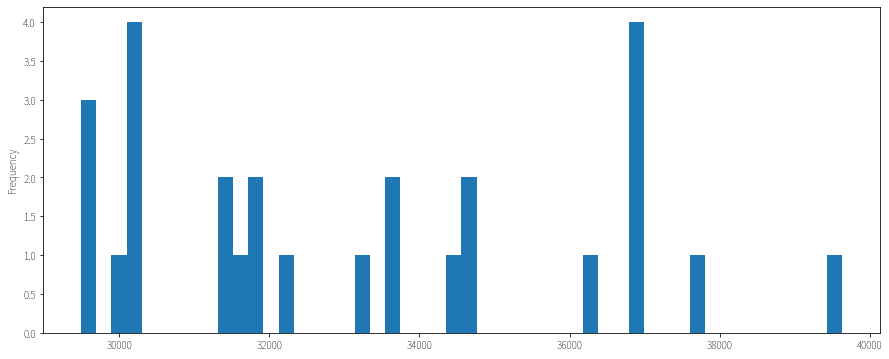

In [73]:
df[df["k_class"]==6]["floor_area"].plot.hist(bins=50)

In [35]:
df[df["k_class"]==6]

,no,name,usage,place,floor_area,floor,structure_type,k_class
28,79 09A396A,東芝府中事業所１２Ａ棟新築工事,付属事務所,東京都府中市,32301.00,0-4-0,S造,6
155,79 10A699A,花王厚木ロジスティクスセンター新築工事,流通施設,神奈川県愛甲郡愛川町,33220.54,0-5-1,S造,6
175,79 10B248A,築地五丁目計画三井造船Ｂ工事設計,一般事務所,東京都中央区,31639.33,1-13-2,S造,6
195,75 10A028A,万代プロジェクト（シルバーボウル跡地計画,物販店舗,新潟県新潟市,31900.26,1-9-1,S造,6
288,79 11B213A,※ブリヂストンプネＰＳＲ第２期工場増築工,ゴムタイヤ製造工場,海外インド マハラシュトラ,31442.80,0-2-0,S造,6
333,64 11B110B,味の素物流拠点分散化計画実施,一般倉庫,0,30000.00,0-3-0,S造,6
358,74 12A064,ホテルオリオンモトブ計画ＶＥ・ＣＤ,リゾ－トホテル,沖縄国頭郡本部町,34751.00,0-12-0,SRC造,6
404,79 11B826A,※安川電機（常州）ロボット工場,機械製造工場,海外中国江蘇省常洲市,29489.00,0-2-1,RC造,6
547,74 12A0641,ホテルオリオンモトブ引渡し対応,リゾ－トホテル,沖縄県国頭郡本部町,34751.00,0-12-0,SRC造,6
556,79 13A351D,ホンダ４輪プラチンブリ新工場（ＰＲ棟）,車両製造工場,海外タイ・プラチンブリ県,33718.00,0-1-0,RC造,6


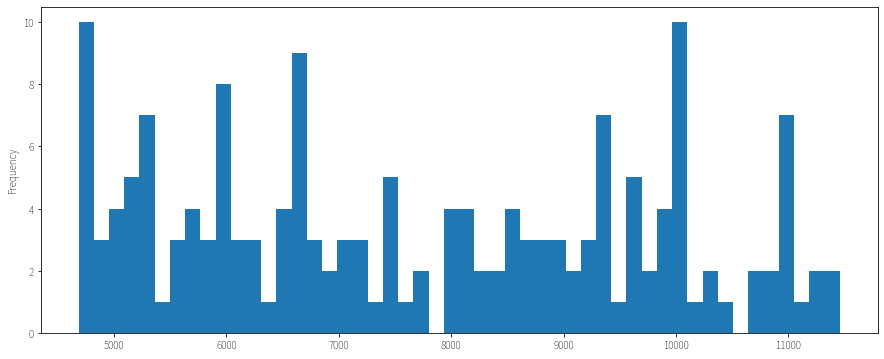

In [74]:
df[df["k_class"]==7]["floor_area"].plot.hist(bins=50)

In [36]:
df[df["k_class"]==7]

,no,name,usage,place,floor_area,floor,structure_type,k_class
5,79 04B878C,市川一丁目計画（テナント対応）,マンションアパ－ト,千葉県市川市,7218.81,1-13-0,RC造,7
17,79 09B033B,シャープ福山第２センタービル計画,付属事務所,広島県福山市,10000.00,0-5-0,S造,7
19,93 09A039,コベルコ建機インド新工場建設工事,研究施設（企業）,海外インド SRI-CITY,5992.00,0-2-0,SRC造,7
22,79 09A276B,日本ガス協会ビル建替事業,一般事務所,東京都港区,7477.29,1-9-1,S造,7
27,74 09A011,ゆめマートうきは新築工事,物販店舗,福岡県うきは市,9934.91,0-1-0,S造,7
40,79 08B173A,川崎御幸ビルディング建替計画,一般事務所,神奈川県川崎市川崎区,6690.80,1-9-1,S造,7
46,74 09A017,オーム電機鳥栖配送センター計画,配送センタ－,佐賀県鳥栖市,8460.00,0-4-0,S造,7
49,79 09B524C,小田急相武台ビル（店舗棟）工事,ショッピングセンタ－,神奈川県座間市,8045.74,0-5-0,S造,7
51,79 09B524B,小田急相武台ビル（仮設店舗）工事,物販店舗,神奈川県座間市,10998.00,0-4-0,S造,7
54,74 10A022,ニチレイロジ九州曽於物流センター新築工事,生産施設,鹿児島県曽於市,8666.46,0-1-0,造,7


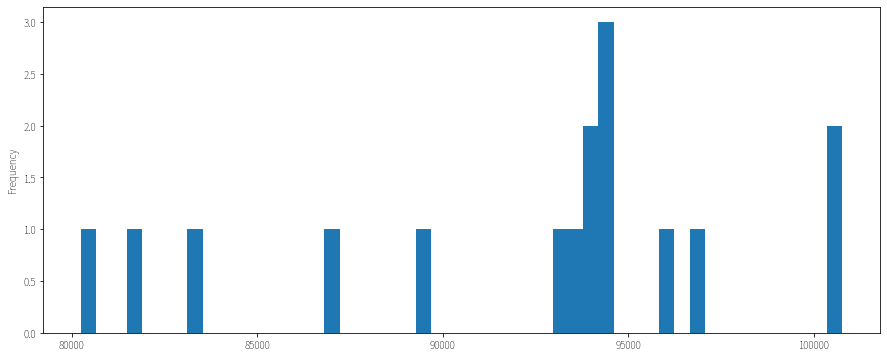

In [75]:
df[df["k_class"]==8]["floor_area"].plot.hist(bins=50)

In [37]:
df[df["k_class"]==8]

,no,name,usage,place,floor_area,floor,structure_type,k_class
79,79 08A090D,東芝四日市メモリ第５製造棟（棟間搬送）,電子機器製造工場,三重県四日市市,96000.00,0-5-0,S造,8
153,93 10A006S,ブリヂストンインド第２工場新築工事,ゴムタイヤ製造工場,海外インド マハラシュトプネ,96846.36,0-1-0,S造,8
171,79 09A181F,ＫＳプロジェクト（外部工事・屋根現寸支援,劇場,東京都中央区,93868.00,4-29-0,SRC造,8
182,79 11A802A,読売新聞東京本社新築工事施工支援業務,一般事務所,東京都千代田区,89409.00,3-33-0,S造,8
192,79 11B392A,キヤノンフィリピン工場新築工事,生産施設,海外フィリピン バタンガス州,83437.69,0-2-0,RC造,8
200,79 07A752H,芝浦一丁目計画（設計）,マンションアパ－ト,東京都港区,100758.02,0-34-1,RC造,8
227,79 11A027B,合肥ニプロ新工場建設工事,医薬品工場,海外中国 安微省,100463.00,0-2-1,RC造,8
263,79 09A181G,ＫＳプロジェクト（舞台大臣囲い計画）,劇場,東京都中央区,93868.00,4-29-0,SRC造,8
408,79 11B506B,東芝四日市２５０棟設計検討（３期）２,電子機器製造工場,三重県四日市市,93642.26,1-6-0,S造,8
425,79 13A351A,※ホンダ４輪プラチンブリ新工場,車両製造工場,海外タイ・プラチンブリ県,94574.00,0-1-0,RC造,8


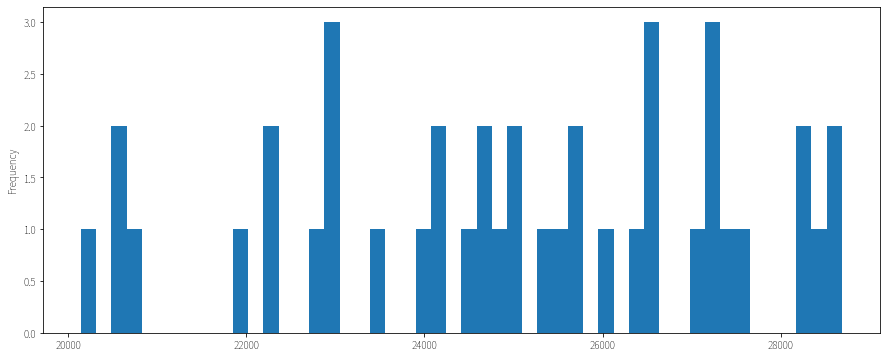

In [76]:
df[df["k_class"]==9]["floor_area"].plot.hist(bins=50)

In [38]:
df[df["k_class"]==9]

,no,name,usage,place,floor_area,floor,structure_type,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,9
6,79 09A540A,花王和歌山新研究施設建設計画,研究施設（教育）,和歌山県和歌山市,22234.09,0-7-2,S造,9
30,79 09A293A,東邦薬品埼玉物流センター計画,流通センタ－,埼玉県南埼玉郡菖蒲町,26000.00,0-3-0,S造,9
102,79 09B150B,セコム新東京病院移転新築工事,病院,千葉県松戸市,24910.84,0-7-1,RC造,9
107,79 09A540D,花王和歌山新研究施設建設計画（変更対応）,研究施設（教育）,和歌山県和歌山市,23000.00,0-7-0,S造,9
108,79 09A540E,花王和歌山新研究施設建設計画（追加工事）,研究施設（教育）,和歌山県和歌山市,24474.00,0-7-0,S造,9
126,79 10A236A,※千代田区四番町計画,マンションアパ－ト,東京都千代田区,21884.00,1-15-1,RC造,9
136,64 10A017,日立ハイテクノロジーズ那珂総合棟構造検討,一般事務所,0,25602.00,1-7-0,S造,9
149,79 10A411B,山梨県防災新館ＰＦＩ整備事業（入手後）,その他事務所,山梨県甲府市,28684.00,2-9-2,S造,9
178,79 10A610A,幸福の科学学園関西中学校・高等学校（仮称,教育研究施設,滋賀県大津市,23530.30,1-4-0,RC造,9
